# Sentiment Analysis and Rating Prediction of Movie Reviews

## intro

### imports

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import spacy
import nltk
from nltk.probability import FreqDist
from wordcloud import WordCloud
from wordcloud import STOPWORDS

import joblib

## definitions

In [2]:
def batch_preprocess_texts(
	texts,
	nlp=None,
	remove_stopwords=True,
	remove_punct=True,
	use_lemmas=False,
	disable=["ner"],
	batch_size=50,
	n_process=-1,
):
	"""Efficiently preprocess a collection of texts using nlp.pipe()

	Args:
		texts (collection of strings): collection of texts to process (e.g. df['text'])
		nlp (spacy pipe), optional): Spacy nlp pipe. Defaults to None; if None, it creates a default 'en_core_web_sm' pipe.
		remove_stopwords (bool, optional): Controls stopword removal. Defaults to True.
		remove_punct (bool, optional): Controls punctuation removal. Defaults to True.
		use_lemmas (bool, optional): lemmatize tokens. Defaults to False.
		disable (list of strings, optional): named pipeline elements to disable. Defaults to ["ner"]: Used with nlp.pipe(disable=disable)
		batch_size (int, optional): Number of texts to process in a batch. Defaults to 50.
		n_process (int, optional): Number of CPU processors to use. Defaults to -1 (meaning all CPU cores).

	Returns:
		list of tokens
	"""
	# from tqdm.notebook import tqdm
	from tqdm import tqdm

	if nlp is None:
		nlp = spacy.load("en_core_web_sm")

	processed_texts = []

	for doc in tqdm(nlp.pipe(texts, disable=disable, batch_size=batch_size, n_process=n_process)):
		tokens = []
		for token in doc:
			# Check if should remove stopwords and if token is stopword
			if (remove_stopwords == True) and (token.is_stop == True):
				# Continue the loop with the next token
				continue

			# Check if should remove stopwords and if token is stopword
			if (remove_punct == True) and (token.is_punct == True):
				continue

            # Check if should remove stopwords and if token is stopword
			if (remove_punct == True) and (token.is_space == True):
				continue

            
			## Determine final form of output list of tokens/lemmas
			if use_lemmas:
				tokens.append(token.lemma_.lower())
			else:
				tokens.append(token.text.lower())

		processed_texts.append(tokens)
	return processed_texts


In [3]:
def get_ngram_measures_finder(tokens, ngrams=2, measure='raw_freq', top_n=None, min_freq = 1,
                             words_colname='Words'):
    import nltk
    if ngrams == 4:
        MeasuresClass = nltk.collocations.QuadgramAssocMeasures
        FinderClass = nltk.collocations.QuadgramCollocationFinder
        
    elif ngrams == 3: 
        MeasuresClass = nltk.collocations.TrigramAssocMeasures
        FinderClass = nltk.collocations.TrigramCollocationFinder
    else:
        MeasuresClass = nltk.collocations.BigramAssocMeasures
        FinderClass = nltk.collocations.BigramCollocationFinder

    measures = MeasuresClass()
    
   
    finder = FinderClass.from_words(tokens)
    finder.apply_freq_filter(min_freq)
    if measure=='pmi':
        scored_ngrams = finder.score_ngrams(measures.pmi)
    else:
        measure='raw_freq'
        scored_ngrams = finder.score_ngrams(measures.raw_freq)

    df_ngrams = pd.DataFrame(scored_ngrams, columns=[words_colname, measure.replace("_",' ').title()])
    if top_n is not None:
        return df_ngrams.head(top_n)
    else:
        return df_ngrams



In [4]:
RANDOM_SEED = 42

## Load the data

Load and inspect the dataset.

In [5]:
fpath = 'Data-NLP\movie_reviews_v2.csv'
df = pd.read_csv (fpath)
original_df = df.copy()
df.head()

,review_id,movie_id,imdb_id,original_title,review,rating
0,64ecc16e83901800af821d50,843,tt0118694,花樣年華,This is a fine piece of cinema from Wong Kar-W...,7.0
1,57086ff5c3a3681d29001512,7443,tt0120630,Chicken Run,"A guilty pleasure for me personally, as I love...",9.0
2,5bb5ac829251410dcb00810c,7443,tt0120630,Chicken Run,Made my roommate who hates stop-motion animati...,6.0
3,5f0c53a013a32000357ec505,7443,tt0120630,Chicken Run,A very good stop-motion animation!\r\n\r\n<em>...,8.0
4,64ecc027594c9400ffe77c91,7443,tt0120630,Chicken Run,"Ok, there is an huge temptation to riddle this...",7.0


How many reviews? 8650

In [6]:
df.shape

(8650, 6)

In [7]:
df['review'].isna().sum()

0

## Preprocessing

What does the distribution of ratings look like?

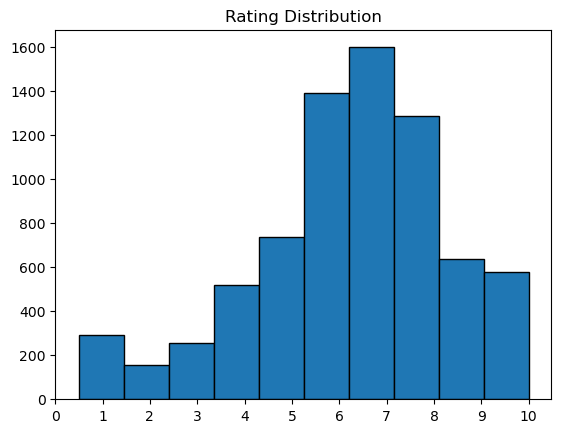

In [8]:
plt.hist(df['rating'], bins=10, edgecolor='black')

plt.title('Rating Distribution')
plt.xticks(np.arange(0, 11, 1));

Any null values?

In [9]:
df.isna().sum()

review_id            0
movie_id             0
imdb_id              0
original_title       0
review               0
rating            1196
dtype: int64

In [10]:
df = df.dropna().reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7454 entries, 0 to 7453
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   review_id       7454 non-null   object 
 1   movie_id        7454 non-null   int64  
 2   imdb_id         7454 non-null   object 
 3   original_title  7454 non-null   object 
 4   review          7454 non-null   object 
 5   rating          7454 non-null   float64
dtypes: float64(1), int64(1), object(4)
memory usage: 349.5+ KB


Use the rating column to create a new target column with two groups: high-rating and low-rating groups.

In [11]:
# We recommend defining "High-rating" reviews as any review with a rating >=9; and "Low-rating" reviews as any review with a rating <=4. The middle ratings between 4 and 9 will be excluded from the analysis.
# You may use an alternative definition for High and Low reviews, but justify your choice in your notebook/README.

df = df.drop(df[(df['rating'] > 4) & (df['rating'] < 9)].index).reset_index(drop=True)
df.head()

,review_id,movie_id,imdb_id,original_title,review,rating
0,57086ff5c3a3681d29001512,7443,tt0120630,Chicken Run,"A guilty pleasure for me personally, as I love...",9.0
1,57b2d23dc3a36837d7000b14,955,tt0120755,Mission: Impossible II,"The first underwhelmed me, but this one straig...",3.0
2,5e9120963679a10018375490,955,tt0120755,Mission: Impossible II,After quite entertainign Mission Impossible I ...,2.0
3,608e2744d8cc4a0058dc4272,2621,tt0122459,Return to Me,"Okay, I will admit I can be a bit of an easy g...",9.0
4,6409202f0e441900e887a17b,4234,tt0134084,Scream 3,**_Scream 3’s_ lackluster screenplay and unima...,4.0


In [12]:
df['sentiment'] = df['rating'].apply(lambda x: 'High' if x >= 9 else 'Low')
df.head()

,review_id,movie_id,imdb_id,original_title,review,rating,sentiment
0,57086ff5c3a3681d29001512,7443,tt0120630,Chicken Run,"A guilty pleasure for me personally, as I love...",9.0,High
1,57b2d23dc3a36837d7000b14,955,tt0120755,Mission: Impossible II,"The first underwhelmed me, but this one straig...",3.0,Low
2,5e9120963679a10018375490,955,tt0120755,Mission: Impossible II,After quite entertainign Mission Impossible I ...,2.0,Low
3,608e2744d8cc4a0058dc4272,2621,tt0122459,Return to Me,"Okay, I will admit I can be a bit of an easy g...",9.0,High
4,6409202f0e441900e887a17b,4234,tt0134084,Scream 3,**_Scream 3’s_ lackluster screenplay and unima...,4.0,Low


## Text Processing

Utilize NLTK and SpaCy for basic text processing, including:

In [13]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [14]:
pre_proc_path = 'Data-NLP/movie_reviews_preprocessed.csv'
if os.path.exists(pre_proc_path):
  df = pd.read_csv(pre_proc_path)

else:
  df['tokenized_text'] = batch_preprocess_texts(df['review'], nlp=nlp, remove_stopwords=True, remove_punct=True, use_lemmas=False)
  df['lemmatized_text'] = batch_preprocess_texts(df['review'], nlp=nlp, remove_stopwords=True, remove_punct=True, use_lemmas=True)
  df['joined_lemmatized_text'] = df['lemmatized_text'].apply(lambda x: ' '.join(x))
  df['joined_tokenized_text'] = df['tokenized_text'].apply(lambda x: ' '.join(x))
  df.to_csv(pre_proc_path)


In [15]:
# save as a joblib file
joblib.dump(df, 'Data-NLP/movie_reviews_preprocessed.pkl')

['Data-NLP/movie_reviews_preprocessed.pkl']

## EDA & Visualization

In [16]:
low_ratings = df.loc[df['sentiment'] == 'Low']
high_ratings = df.loc[df['sentiment'] == 'High']

low_ratings.head()

,Unnamed: 0,review_id,movie_id,imdb_id,original_title,review,rating,sentiment,tokenized_text,lemmatized_text,joined_lemmatized_text,joined_tokenized_text
1,1,57b2d23dc3a36837d7000b14,955,tt0120755,Mission: Impossible II,"The first underwhelmed me, but this one straig...",3.0,Low,"['underwhelmed', 'straight', 'bored', 'course'...","['underwhelme', 'straight', 'bore', 'course', ...",underwhelme straight bore course see hunt clim...,underwhelmed straight bored course seeing hunt...
2,2,5e9120963679a10018375490,955,tt0120755,Mission: Impossible II,After quite entertainign Mission Impossible I ...,2.0,Low,"['entertainign', 'mission', 'impossible', 'sec...","['entertainign', 'mission', 'impossible', 'sec...",entertainign mission impossible second install...,entertainign mission impossible second install...
4,4,6409202f0e441900e887a17b,4234,tt0134084,Scream 3,**_Scream 3’s_ lackluster screenplay and unima...,4.0,Low,"['scream', '3', 'lackluster', 'screenplay', 'u...","['scream', '3', 'lackluster', 'screenplay', 'u...",scream 3 lackluster screenplay unimaginative k...,scream 3 lackluster screenplay unimaginative k...
9,9,63578ba8c8a2d4008a00ff77,12211,tt0144964,Highlander: Endgame,**There should have been only one!**\r\n\r\nIf...,1.0,Low,"['highlander', '2', 'complete', 'disgrace', 'h...","['highlander', '2', 'complete', 'disgrace', 'h...",highlander 2 complete disgrace highlander 3 tr...,highlander 2 complete disgrace highlander 3 tr...
13,13,6110271465e0a2002683d2b6,479,tt0162650,Shaft,_**A black detective in Gotham desperately wan...,4.0,Low,"['black', 'detective', 'gotham', 'desperately'...","['black', 'detective', 'gotham', 'desperately'...",black detective gotham desperately want nail s...,black detective gotham desperately wants nail ...


In [17]:
high_ratings.head()

,Unnamed: 0,review_id,movie_id,imdb_id,original_title,review,rating,sentiment,tokenized_text,lemmatized_text,joined_lemmatized_text,joined_tokenized_text
0,0,57086ff5c3a3681d29001512,7443,tt0120630,Chicken Run,"A guilty pleasure for me personally, as I love...",9.0,High,"['guilty', 'pleasure', 'personally', 'love', '...","['guilty', 'pleasure', 'personally', 'love', '...",guilty pleasure personally love great escape w...,guilty pleasure personally love great escape w...
3,3,608e2744d8cc4a0058dc4272,2621,tt0122459,Return to Me,"Okay, I will admit I can be a bit of an easy g...",9.0,High,"['okay', 'admit', 'bit', 'easy', 'grader', 'co...","['okay', 'admit', 'bit', 'easy', 'grader', 'co...",okay admit bit easy grader come romantic comed...,okay admit bit easy grader comes romantic come...
5,5,5570c897c3a368709c000bca,2787,tt0134847,Pitch Black,All you people are so scared of me. Most days ...,9.0,High,"['people', 'scared', 'days', 'compliment', 'ai...","['people', 'scared', 'day', 'compliment', 'be'...",people scared day compliment be got to worry p...,people scared days compliment ai got ta worry ...
6,6,5b92026d0e0a26609c005caa,2787,tt0134847,Pitch Black,One of those few movies that most people don't...,9.0,High,"['movies', 'people', 'care', 'personally', 'th...","['movie', 'people', 'care', 'personally', 'thi...",movie people care personally think criminally ...,movies people care personally think criminally...
7,7,5f98ecffae36680036bc7170,2787,tt0134847,Pitch Black,The movie that put Vin Diesel on the map as Ri...,9.0,High,"['movie', 'vin', 'diesel', 'map', 'riddick', '...","['movie', 'vin', 'diesel', 'map', 'riddick', '...",movie vin diesel map riddick crooked anti hero...,movie vin diesel map riddick crooked anti hero...


Create word clouds to visualize the most frequent and significant words in each group.

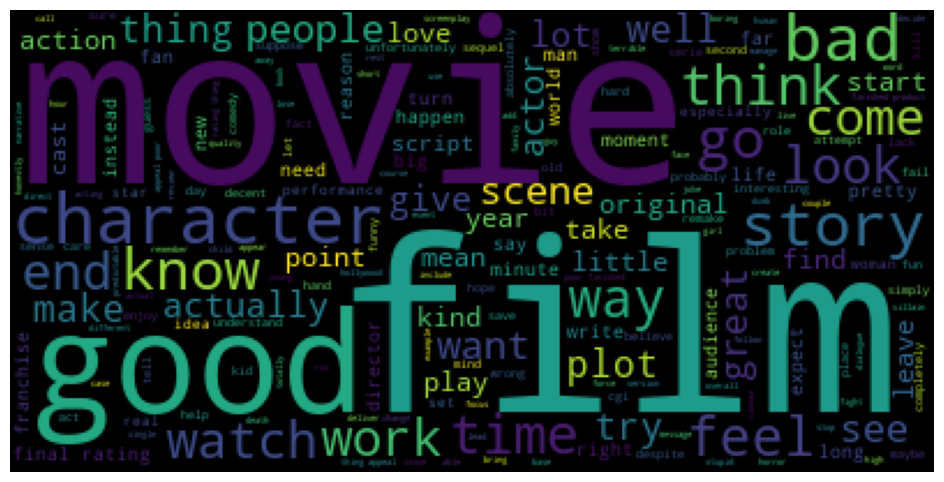

In [18]:
cloud_low = WordCloud(random_state = RANDOM_SEED).generate(' '.join(low_ratings['joined_lemmatized_text']))

plt.figure(figsize = (12, 6))
plt.imshow(cloud_low)
plt.axis('off');

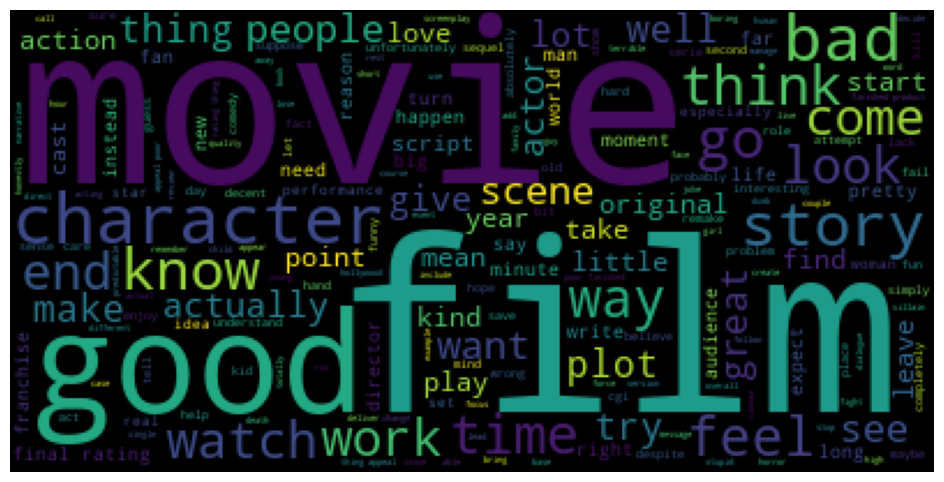

In [19]:
cloud_high = WordCloud(random_state = RANDOM_SEED).generate(' '.join(high_ratings['joined_lemmatized_text']))

plt.figure(figsize = (12, 6))
plt.imshow(cloud_low)
plt.axis('off');

Save your wordclouds as .png files in the "Images/" folder in your repo.

Apply nltk's FreqDist class to compare the frequency distribution of words in the review groups.

In [20]:
# tokens_low = batch_preprocess_texts(low_ratings['review'], batch_size = 1000)
# tokens_low = tokens_low[0]

In [21]:
# tokens_high = batch_preprocess_texts(high_ratings['review'], batch_size = 1000)
# tokens_high = tokens_high[0]

compare low and high rated

In [22]:
# pd.DataFrame([tokens_low, tokens_high]).T.rename(columns={0: 'low_rated', 1: 'high_rated'})

In [23]:
joined_lemmatized_string = ' '.join(df['joined_lemmatized_text'])
joined_lemmatized_list = joined_lemmatized_string.split()
joined_lemmatized_list[:10]

['guilty',
 'pleasure',
 'personally',
 'love',
 'great',
 'escape',
 'work',
 'see',
 'year',
 'rightfully']

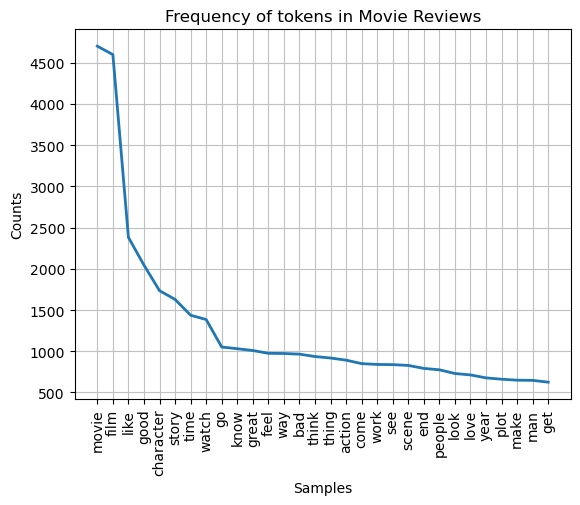

In [24]:
dist = FreqDist(joined_lemmatized_list)

# Plot top 30
dist.plot(30, title = 'Frequency of tokens in Movie Reviews');
# dist

In [25]:
joined_lemmatized_string_high = ' '.join(high_ratings['joined_lemmatized_text'])
joined_lemmatized_list_high = joined_lemmatized_string_high.split()
joined_lemmatized_list_high[:10]

['guilty',
 'pleasure',
 'personally',
 'love',
 'great',
 'escape',
 'work',
 'see',
 'year',
 'rightfully']

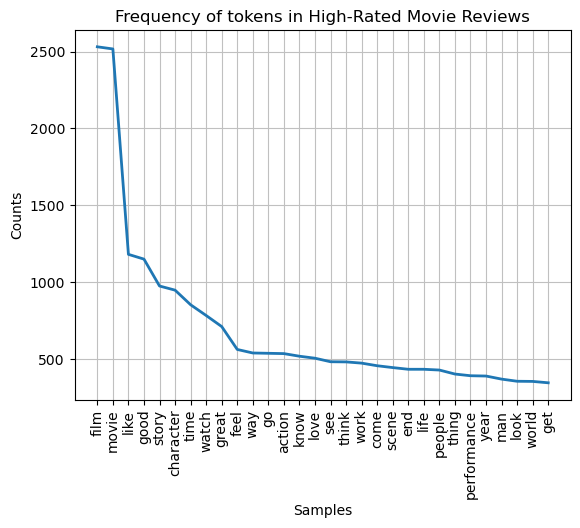

In [26]:
dist = FreqDist(joined_lemmatized_list_high)

# Plot top 30
dist.plot(30, title = 'Frequency of tokens in High-Rated Movie Reviews');
# dist

In [27]:
joined_lemmatized_string_low = ' '.join(low_ratings['joined_lemmatized_text'])
joined_lemmatized_list_low = joined_lemmatized_string_low.split()
joined_lemmatized_list_low[:10]

['underwhelme',
 'straight',
 'bore',
 'course',
 'see',
 'hunt',
 'climb',
 'mountain',
 'harness',
 'impressive']

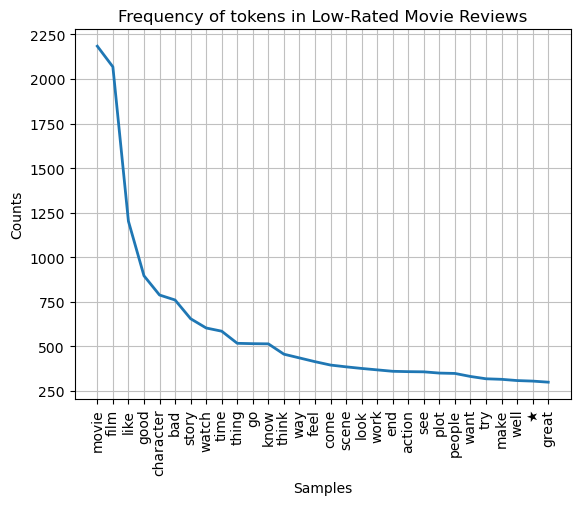

In [28]:
dist = FreqDist(joined_lemmatized_list_low)

# Plot top 30
dist.plot(30, title = 'Frequency of tokens in Low-Rated Movie Reviews');
# dist

In [29]:
# Remember, you can use this analysis to identify additional custom EDA stop words to use for visualization. (e.g., if the words are common in both groups)
custom_stops = ['movie', 'film', 'good', 'story', 'character', 'ii', '★', '45',	'½', 'time', 'watch', 'feel', 'think', 'go', 'know']

stops = [*STOPWORDS, *custom_stops]

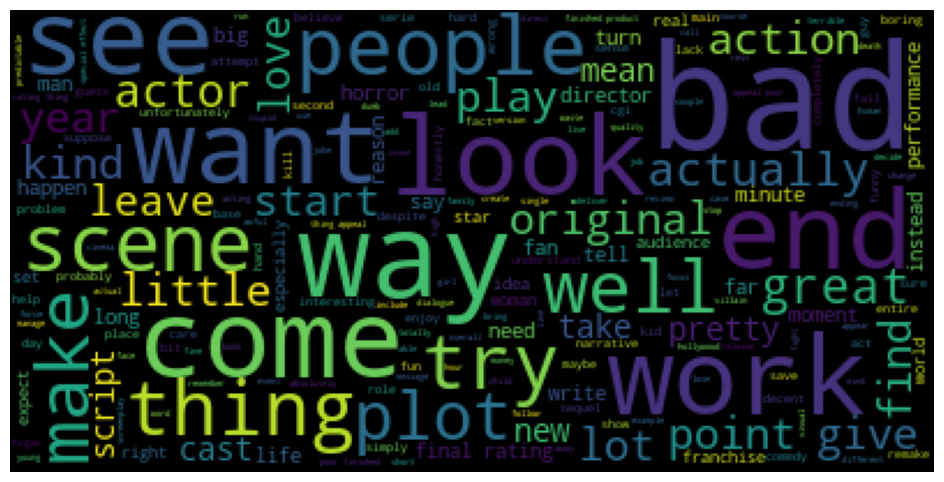

In [30]:
# # Remove stopwords from the wordcloud
low_cloud = WordCloud(random_state=123, stopwords=stops).generate(' '.join(low_ratings['joined_lemmatized_text']))

plt.figure(figsize = (12, 6))
plt.imshow(low_cloud);
plt.axis('off');

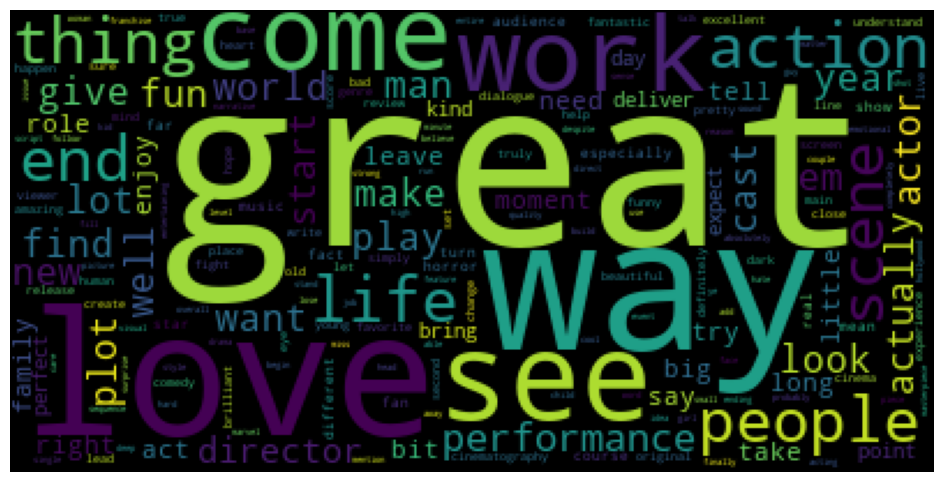

In [31]:
# # Remove stopwords from the wordcloud
high_cloud = WordCloud(random_state=123, stopwords=stops).generate(' '.join(high_ratings['joined_lemmatized_text']))

plt.figure(figsize = (12, 6))
plt.imshow(high_cloud);
plt.axis('off');

In [32]:
low_rating_freqs = pd.DataFrame(low_cloud.words_, index = range(0,200)).T.reset_index().rename(columns = {'index': 'word', 0: 'frequency'})[['word', 'frequency']]
high_rating_freqs = pd.DataFrame(high_cloud.words_, index = range(0,200)).T.reset_index().rename(columns = {'index': 'word', 0: 'frequency'})[['word', 'frequency']]

In [33]:
low_rating_freqs.head(10)

,word,frequency
0,bad,1.000000
1,way,0.626100
2,come,0.558651
3,end,0.533724
4,look,0.526393
5,work,0.526393
6,see,0.510264
7,want,0.485337
8,people,0.483871
9,scene,0.469208


In [34]:
high_rating_freqs.head(10)

,word,frequency
0,great,1.000000
1,way,0.801858
2,love,0.736842
3,see,0.733746
4,come,0.685759
5,work,0.656347
6,people,0.628483
7,end,0.606811
8,thing,0.588235
9,action,0.588235


In [35]:
df.head()

,Unnamed: 0,review_id,movie_id,imdb_id,original_title,review,rating,sentiment,tokenized_text,lemmatized_text,joined_lemmatized_text,joined_tokenized_text
0,0,57086ff5c3a3681d29001512,7443,tt0120630,Chicken Run,"A guilty pleasure for me personally, as I love...",9.0,High,"['guilty', 'pleasure', 'personally', 'love', '...","['guilty', 'pleasure', 'personally', 'love', '...",guilty pleasure personally love great escape w...,guilty pleasure personally love great escape w...
1,1,57b2d23dc3a36837d7000b14,955,tt0120755,Mission: Impossible II,"The first underwhelmed me, but this one straig...",3.0,Low,"['underwhelmed', 'straight', 'bored', 'course'...","['underwhelme', 'straight', 'bore', 'course', ...",underwhelme straight bore course see hunt clim...,underwhelmed straight bored course seeing hunt...
2,2,5e9120963679a10018375490,955,tt0120755,Mission: Impossible II,After quite entertainign Mission Impossible I ...,2.0,Low,"['entertainign', 'mission', 'impossible', 'sec...","['entertainign', 'mission', 'impossible', 'sec...",entertainign mission impossible second install...,entertainign mission impossible second install...
3,3,608e2744d8cc4a0058dc4272,2621,tt0122459,Return to Me,"Okay, I will admit I can be a bit of an easy g...",9.0,High,"['okay', 'admit', 'bit', 'easy', 'grader', 'co...","['okay', 'admit', 'bit', 'easy', 'grader', 'co...",okay admit bit easy grader come romantic comed...,okay admit bit easy grader comes romantic come...
4,4,6409202f0e441900e887a17b,4234,tt0134084,Scream 3,**_Scream 3’s_ lackluster screenplay and unima...,4.0,Low,"['scream', '3', 'lackluster', 'screenplay', 'u...","['scream', '3', 'lackluster', 'screenplay', 'u...",scream 3 lackluster screenplay unimaginative k...,scream 3 lackluster screenplay unimaginative k...


In [36]:
new_stopwords = ['way', 'work', 'come', 'end', 'see', 'people']
stops.extend(new_stopwords)

new low ratings cloud

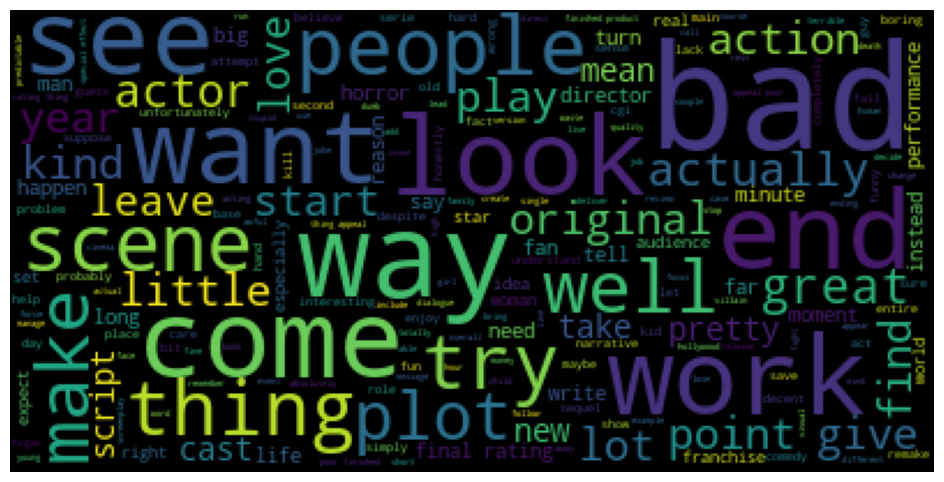

In [37]:
# # Remove stopwords from the wordcloud
new_low_cloud = WordCloud(random_state=123, stopwords=stops).generate(' '.join(low_ratings['joined_lemmatized_text']))

plt.figure(figsize = (12, 6))
plt.imshow(low_cloud);
plt.axis('off');

new high ratings cloud

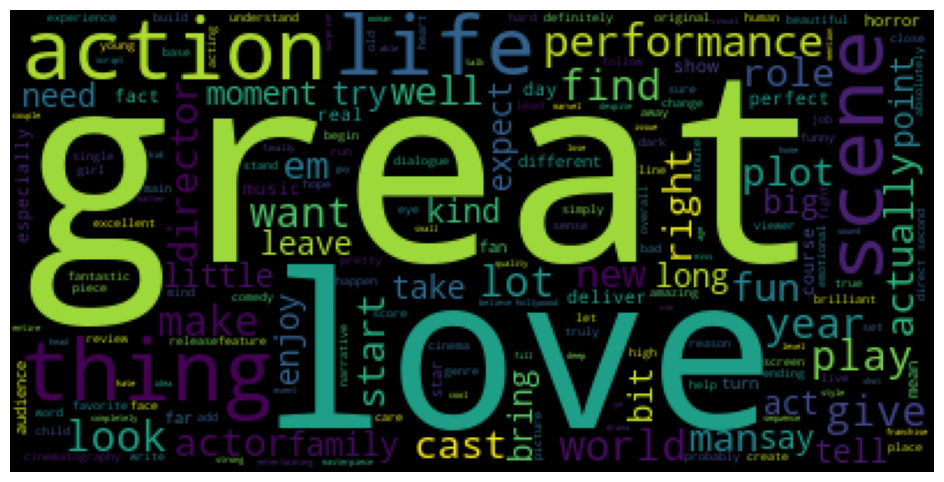

In [38]:
# # Remove stopwords from the wordcloud
high_cloud = WordCloud(random_state=123, stopwords=stops).generate(' '.join(high_ratings['joined_lemmatized_text']))

plt.figure(figsize = (12, 6))
plt.imshow(high_cloud);
plt.axis('off');

new high ratings FreqDist

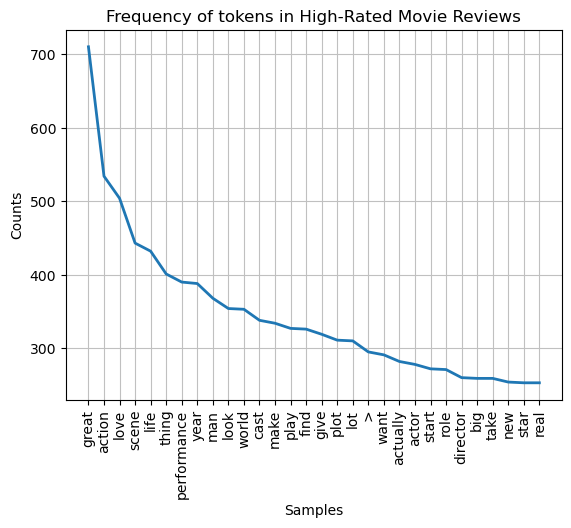

In [39]:
dist = FreqDist([word for word in joined_lemmatized_list_high if word not in stops])

# Plot top 30
dist.plot(30, title = 'Frequency of tokens in High-Rated Movie Reviews');
# dist

new low ratings FreqDist

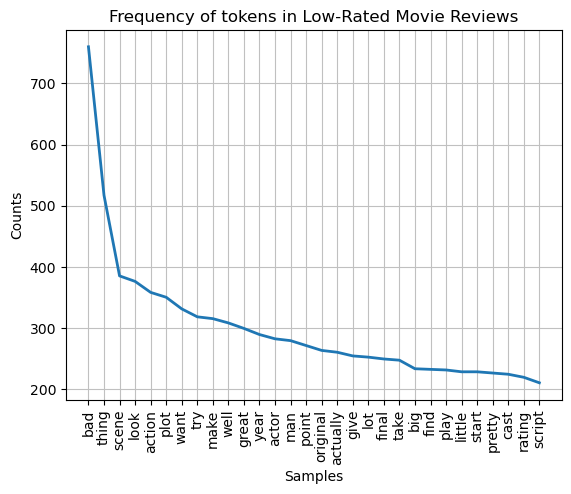

FreqDist({'bad': 760, 'thing': 517, 'scene': 385, 'look': 376, 'action': 358, 'plot': 350, 'want': 331, 'try': 318, 'make': 315, 'well': 308, ...})

In [40]:
dist = FreqDist([word for word in joined_lemmatized_list_low if word not in stops])

# Plot top 30
dist.plot(30, title = 'Frequency of tokens in Low-Rated Movie Reviews');
dist

## Compare n-grams

get n-grams

In [41]:
high_tokens = high_ratings['tokenized_text'].explode().to_list()
low_tokens = low_ratings['tokenized_text'].explode().to_list()

In [42]:
two_grams_high = get_ngram_measures_finder(high_tokens)

In [43]:
two_grams_high.head(10)


,Words,Raw Freq
0,"(['10/10', 'best', 'mystery', 'movies', 'privi...",0.000837
1,"(['127', 'hours', 'depicts', 'true', 'story', ...",0.000837
2,"(['16', 'blocks', 'incredibly', 'atmospheric',...",0.000837
3,"(['1917', 'best', 'war', 'films', 'cinema', 'h...",0.000837
4,"(['1st', 'month', '2017', 'saw', 'officially',...",0.000837
5,"(['1st', 'time', 'fun', 'albeit', 'bit', 'revi...",0.000837
6,"(['21', 'grams', 'movie', 'beautifully', 'cons...",0.000837
7,"(['3', 'couples', 'raj', 'bobby', 'deol', 'san...",0.000837
8,"(['<', ""em>'a"", 'royal', ""affair'</em"", '>', '...",0.000837
9,"(['<', ""em>'riders"", ""justice'</em"", '>', 'ent...",0.000837


In [44]:
two_grams_low = get_ngram_measures_finder(low_tokens)

In [45]:
two_grams_low.head(10)

,Words,Raw Freq
0,"(['state', 'art', 'special', 'effects', 'revol...",0.001634
1,"(['05', 'worst', 'kong', 'movies', 'mainly', '...",0.000817
2,"(['1', 'star', 'solely', 'fleeting', 'presence...",0.000817
3,"(['1960', 'great', 'year', 'suspense', 'films'...",0.000817
4,"(['1960', 'great', 'year', 'suspense', 'films'...",0.000817
5,"(['1975', 'richard', 'dreyfuss', 'starred', 'j...",0.000817
6,"(['2', 'hours', 'tedious', 'boring', 'nonsense...",0.000817
7,"(['2', 'reviews', '8', 'star', '1', 'star', 'w...",0.000817
8,"(['2006', 'year', 'turned', 'bond', 'common', ...",0.000817
9,"(['2010', 'remake', 'old', 'classic', 'origina...",0.000817


In [46]:
# high_tokens.count('*ht')

In [47]:
get_ngram_measures_finder(high_tokens, ngrams=3).head(20)

,Words,Raw Freq
0,"(['10/10', 'best', 'mystery', 'movies', 'privi...",0.000837
1,"(['127', 'hours', 'depicts', 'true', 'story', ...",0.000837
2,"(['16', 'blocks', 'incredibly', 'atmospheric',...",0.000837
3,"(['1917', 'best', 'war', 'films', 'cinema', 'h...",0.000837
4,"(['1st', 'month', '2017', 'saw', 'officially',...",0.000837
5,"(['1st', 'time', 'fun', 'albeit', 'bit', 'revi...",0.000837
6,"(['21', 'grams', 'movie', 'beautifully', 'cons...",0.000837
7,"(['3', 'couples', 'raj', 'bobby', 'deol', 'san...",0.000837
8,"(['<', ""em>'a"", 'royal', ""affair'</em"", '>', '...",0.000837
9,"(['<', ""em>'riders"", ""justice'</em"", '>', 'ent...",0.000837


Sentiment Analysis

In [48]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [49]:
# # The download below only needs to be completed once
# nltk.download('vader_lexicon')

In [50]:
sia = SentimentIntensityAnalyzer()

df['sentiment_scores'] = df['review'].map(sia.polarity_scores)
review_scores = df['sentiment_scores'].apply(pd.Series)
df = pd.concat([df, review_scores], axis=1).drop('sentiment_scores', axis=1)

In [51]:
sia = SentimentIntensityAnalyzer()

high_ratings['sentiment_scores'] = high_ratings['review'].map(sia.polarity_scores)
review_scores = high_ratings['sentiment_scores'].apply(pd.Series)
high_ratings = pd.concat([high_ratings, review_scores], axis=1).drop('sentiment_scores', axis=1)

In [52]:
sia = SentimentIntensityAnalyzer()

low_ratings['sentiment_scores'] = low_ratings['review'].map(sia.polarity_scores)
review_scores = low_ratings['sentiment_scores'].apply(pd.Series)
low_ratings = pd.concat([low_ratings, review_scores], axis=1).drop('sentiment_scores', axis=1)

In [53]:
high_ratings.head()

,Unnamed: 0,review_id,movie_id,imdb_id,original_title,review,rating,sentiment,tokenized_text,lemmatized_text,joined_lemmatized_text,joined_tokenized_text,neg,neu,pos,compound
0,0,57086ff5c3a3681d29001512,7443,tt0120630,Chicken Run,"A guilty pleasure for me personally, as I love...",9.0,High,"['guilty', 'pleasure', 'personally', 'love', '...","['guilty', 'pleasure', 'personally', 'love', '...",guilty pleasure personally love great escape w...,guilty pleasure personally love great escape w...,0.053,0.587,0.360,0.9450
3,3,608e2744d8cc4a0058dc4272,2621,tt0122459,Return to Me,"Okay, I will admit I can be a bit of an easy g...",9.0,High,"['okay', 'admit', 'bit', 'easy', 'grader', 'co...","['okay', 'admit', 'bit', 'easy', 'grader', 'co...",okay admit bit easy grader come romantic comed...,okay admit bit easy grader comes romantic come...,0.030,0.710,0.260,0.9942
5,5,5570c897c3a368709c000bca,2787,tt0134847,Pitch Black,All you people are so scared of me. Most days ...,9.0,High,"['people', 'scared', 'days', 'compliment', 'ai...","['people', 'scared', 'day', 'compliment', 'be'...",people scared day compliment be got to worry p...,people scared days compliment ai got ta worry ...,0.076,0.802,0.121,0.9859
6,6,5b92026d0e0a26609c005caa,2787,tt0134847,Pitch Black,One of those few movies that most people don't...,9.0,High,"['movies', 'people', 'care', 'personally', 'th...","['movie', 'people', 'care', 'personally', 'thi...",movie people care personally think criminally ...,movies people care personally think criminally...,0.222,0.652,0.126,-0.3391
7,7,5f98ecffae36680036bc7170,2787,tt0134847,Pitch Black,The movie that put Vin Diesel on the map as Ri...,9.0,High,"['movie', 'vin', 'diesel', 'map', 'riddick', '...","['movie', 'vin', 'diesel', 'map', 'riddick', '...",movie vin diesel map riddick crooked anti hero...,movie vin diesel map riddick crooked anti hero...,0.000,0.923,0.077,0.3818


Compare the sentiments of high-rating and low-rating texts.
Compare the compound sentiment scores for high and low-rating reviews.

In [54]:
high_ratings['review'].map(sia.polarity_scores).apply(pd.Series)

,neg,neu,pos,compound
0,0.053,0.587,0.360,0.9450
3,0.030,0.710,0.260,0.9942
5,0.076,0.802,0.121,0.9859
6,0.222,0.652,0.126,-0.3391
7,0.000,0.923,0.077,0.3818
...,...,...,...,...
2414,0.142,0.731,0.128,-0.2866
2415,0.050,0.739,0.211,0.9977
2416,0.355,0.645,0.000,-0.2960
2417,0.074,0.732,0.195,0.9868


In [55]:
low_ratings['review'].map(sia.polarity_scores).apply(pd.Series)

,neg,neu,pos,compound
1,0.186,0.704,0.110,-0.8724
2,0.135,0.773,0.093,-0.5267
4,0.221,0.655,0.125,-0.9934
9,0.150,0.734,0.116,-0.9530
13,0.158,0.708,0.134,-0.8074
...,...,...,...,...
2404,0.400,0.600,0.000,-0.8750
2405,0.070,0.778,0.152,0.2732
2410,0.126,0.692,0.182,0.9889
2412,0.216,0.784,0.000,-0.6597


In [56]:
high_ratings['compound'].describe()

count    1195.000000
mean        0.702352
std         0.538278
min        -0.998200
25%         0.743000
50%         0.954500
75%         0.990600
max         0.999800
Name: compound, dtype: float64

In [63]:
low_ratings['compound'].describe()

count    1224.000000
mean       -0.011619
std         0.759396
min        -0.998700
25%        -0.778525
50%        -0.135100
75%         0.815650
max         0.999200
Name: compound, dtype: float64

Which review polarity scores don't match the ratings?

In [58]:
low_ratings.loc[low_ratings['compound'] > 0]

,Unnamed: 0,review_id,movie_id,imdb_id,original_title,review,rating,sentiment,tokenized_text,lemmatized_text,joined_lemmatized_text,joined_tokenized_text,neg,neu,pos,compound
19,19,5dd0f0b6b76cbb00137ad8f4,18041,tt0176783,Gossip,WHAT A GREAT CAST FOR SUCH A CHEAP FILM.\r\n\r...,4.0,Low,"['great', 'cast', 'cheap', 'film', 'descriptio...","['great', 'cast', 'cheap', 'film', 'descriptio...",great cast cheap film description college stud...,great cast cheap film description college stud...,0.090,0.713,0.196,0.8695
32,32,61fc416f5f4b73006c946bee,11478,tt0192614,The Skulls,Pretty typical movie from the early aughts wit...,4.0,Low,"['pretty', 'typical', 'movie', 'early', 'aught...","['pretty', 'typical', 'movie', 'early', 'aught...",pretty typical movie early aught attractive so...,pretty typical movie early aughts attractive s...,0.095,0.727,0.178,0.6523
36,36,654b042c1ac2927b2ebddc17,6282,tt0200550,Coyote Ugly,**An excuse to make a film full of women swayi...,3.0,Low,"['excuse', 'film', 'women', 'swaying', 'seduct...","['excuse', 'film', 'woman', 'sway', 'seductive...",excuse film woman sway seductively hint softco...,excuse film women swaying seductively hint sof...,0.071,0.748,0.181,0.9967
38,38,4fce88ed19c29523e0000069,10763,tt0205271,Dr. T & the Women,"After writing three high-praise reviews, I tri...",1.0,Low,"['writing', 'high', 'praise', 'reviews', 'trie...","['write', 'high', 'praise', 'review', 'try', '...",write high praise review try think bad movie s...,writing high praise reviews tried think worst ...,0.089,0.769,0.142,0.9408
45,45,5c83e502c3a36839d4d212f6,10481,tt0211181,102 Dalmatians,I remember loving this film as a kid. Rewatchi...,4.0,Low,"['remember', 'loving', 'film', 'kid', 'rewatch...","['remember', 'love', 'film', 'kid', 'rewatche'...",remember love film kid rewatche film adult fil...,remember loving film kid rewatching film adult...,0.044,0.844,0.112,0.7845
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2395,2395,652a5068358da700e3bd1a32,299054,tt3291150,Expend4bles,A B grade action flick masquerading as a A lis...,4.0,Low,"['b', 'grade', 'action', 'flick', 'masqueradin...","['b', 'grade', 'action', 'flick', 'masquerade'...",b grade action flick masquerade list title rea...,b grade action flick masquerading list title r...,0.039,0.719,0.242,0.9747
2396,2396,652aee33ea84c700ca1090f0,299054,tt3291150,Expend4bles,I love all 3 parts before this 3rd class movie...,4.0,Low,"['love', '3', 'parts', '3rd', 'class', 'movie'...","['love', '3', 'part', '3rd', 'class', 'movie',...",love 3 part 3rd class movie story classic bad ...,love 3 parts 3rd class movie story classic bad...,0.114,0.720,0.166,0.2721
2405,2405,6545f8356beaea00c9fbb6ab,455476,tt6528290,Knights of the Zodiac,The least a goddess could do is ask for better...,3.0,Low,"['goddess', 'ask', 'better', 'writers', 'fight...","['goddess', 'ask', 'well', 'writer', 'fight', ...",goddess ask well writer fight scene good gee g...,goddess ask better writers fight scenes good g...,0.070,0.778,0.152,0.2732
2410,2410,64c30a506331b200ff0a64d7,678512,tt7599146,Sound of Freedom,As someone who was a victim of child sexual ab...,1.0,Low,"['victim', 'child', 'sexual', 'abuse', 'admitt...","['victim', 'child', 'sexual', 'abuse', 'admitt...",victim child sexual abuse admittedly like trum...,victim child sexual abuse admittedly likes tru...,0.126,0.692,0.182,0.9889


In [59]:
high_ratings.loc[high_ratings['compound'] < 0]

,Unnamed: 0,review_id,movie_id,imdb_id,original_title,review,rating,sentiment,tokenized_text,lemmatized_text,joined_lemmatized_text,joined_tokenized_text,neg,neu,pos,compound
6,6,5b92026d0e0a26609c005caa,2787,tt0134847,Pitch Black,One of those few movies that most people don't...,9.0,High,"['movies', 'people', 'care', 'personally', 'th...","['movie', 'people', 'care', 'personally', 'thi...",movie people care personally think criminally ...,movies people care personally think criminally...,0.222,0.652,0.126,-0.3391
14,14,5fed7c50ede1b0003e64eab9,16,tt0168629,Dancer in the Dark,Dazzling Björk in this indictment against the ...,10.0,High,"['dazzling', 'björk', 'indictment', 'death', '...","['dazzle', 'björk', 'indictment', 'death', 'se...",dazzle björk indictment death sentence tight c...,dazzling björk indictment death sentence tight...,0.176,0.766,0.059,-0.5574
21,21,557c9680c3a368632300242e,641,tt0180093,Requiem for a Dream,Shattering expose of the fallible human condit...,9.0,High,"['shattering', 'expose', 'fallible', 'human', ...","['shatter', 'expose', 'fallible', 'human', 'co...",shatter expose fallible human condition darren...,shattering expose fallible human condition dar...,0.148,0.729,0.123,-0.7907
33,33,55acc12cc3a3682ff40098c3,9532,tt0195714,Final Destination,I'll see you soon!\r\n\r\nBefore taking off fo...,9.0,High,"['soon', 'taking', 'paris', 'alex', 'browning'...","['soon', 'take', 'paris', 'alex', 'browning', ...",soon take paris alex browning vision plane go ...,soon taking paris alex browning vision plane g...,0.259,0.580,0.161,-0.9920
76,76,5e94d6fd0792e100143ad07c,5955,tt0237572,The Pledge,There can't be such devils out there. \r\n\r\n...,9.0,High,"['devils', 'pledge', 'directed', 'sean', 'penn...","['devil', 'pledge', 'direct', 'sean', 'penn', ...",devil pledge direct sean penn adapt screenplay...,devils pledge directed sean penn adapted scree...,0.118,0.800,0.082,-0.9755
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2287,2287,63c6f303de11e50087cfecfb,436270,tt6443346,Black Adam,"OK, this isn't a bad movie. \r\n\r\nBut, it a...",10.0,High,"['ok', 'bad', 'movie', 'bit', 'cgi', 'like', '...","['ok', 'bad', 'movie', 'bit', 'cgi', 'like', '...",ok bad movie bit cgi like nowadays think moder...,ok bad movie bit cgi like nowadays think moder...,0.127,0.754,0.119,-0.7430
2290,2290,62f573c9abdec000878703e6,545611,tt6710474,Everything Everywhere All at Once,Full Analysis at Spotamovie.com - **Intro** - ...,9.0,High,"['analysis', 'spotamovie.com', 'intro', 'best'...","['analysis', 'spotamovie.com', 'intro', 'good'...",analysis spotamovie.com intro good movie 2022 ...,analysis spotamovie.com intro best movies 2022...,0.151,0.723,0.126,-0.7987
2398,2398,653a4ad08a0e9b010b29016c,507089,tt4589218,Five Nights at Freddy's,"FNAF was great, Kinda wish it had blood, Every...",9.0,High,"['fnaf', 'great', 'kinda', 'wish', 'blood', 'k...","['fnaf', 'great', 'kinda', 'wish', 'blood', 'k...",fnaf great kinda wish blood kill offscreen dar...,fnaf great kinda wish blood kill offscreen dar...,0.277,0.531,0.192,-0.5984
2414,2414,6499e4de62f3350127477b22,569094,tt9362722,Spider-Man: Across the Spider-Verse,"I don't know, but in my humble opinion, the pu...",10.0,High,"['know', 'humble', 'opinion', 'punk', 'spider'...","['know', 'humble', 'opinion', 'punk', 'spider'...",know humble opinion punk spider man need look ...,know humble opinion punk spider man needed loo...,0.142,0.731,0.128,-0.2866


 Why do you think this is?
* Reviews for high-rated movies with dark themes seem to have negative sentiment scores. Words like "shatter", "expose", and "fallible", which in context are praise for the movie, bring down the sentiment score